In [7]:
from google.colab import drive
drive.mount('/content/drive')

from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Add
from keras.layers.core import Activation

import numpy as np
from numpy import genfromtxt
from numpy.testing import assert_allclose
from scipy import misc
import matplotlib.pyplot as plt

import os
import sys
from PIL import Image
from tqdm import tqdm

sys.path.insert(1, 'drive/My Drive/Rosneft Seismic/models/modules')

from dice_metric import dice, dice_border, dice_coef, dice_coef_loss
from uresnet_v3 import *
from load_data import *



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def connect_test_img2(m, x):

  #Concatenate the resulting masks into one image(y) with shape (384, m)
  
  k = m // 384
  if (m == 384): y = x
  else:
    y = np.copy(x[0])
    for i in range(1, k):
      y = np.concatenate((y, x[i]), axis = 1)
    if (m%384 > 0):
      y = y[:, 0 : m-384]
      y = np.concatenate((y, x[k]), axis = 1)
  return y

In [8]:
x_test = []
x_test = load_test()

100%|██████████| 2751/2751 [00:58<00:00, 47.03it/s]


In [0]:
x_test[0]
m, x_cut_test = cut_test_img(x_test[0])

In [28]:
x_cut_test[2]

array([[-0.905642  , -0.905642  , -0.905642  , ...,  1.2217349 ,
         1.257125  ,  1.2748202 ],
       [-0.9030125 , -0.9030125 , -0.9030125 , ...,  1.0270886 ,
         1.0447838 ,  1.0624789 ],
       [-0.90739495, -0.90739495, -0.90739495, ...,  0.76166207,
         0.7793572 ,  0.79705226],
       ...,
       [-0.93105954, -0.931936  , -0.931936  , ...,  1.1332593 ,
         1.080174  ,  1.0624789 ],
       [-0.93105954, -0.931936  , -0.931936  , ...,  1.1509545 ,
         1.1332593 ,  1.080174  ],
       [-0.93105954, -0.93105954, -0.93105954, ...,  1.1509545 ,
         1.1332593 ,  1.1332593 ]], dtype=float32)

In [23]:
img = connect_test_img2(m, x_cut_test)

(384, 768)
(3, 384, 384)


In [26]:
img

array([[ 0.13407001,  0.13407001,  0.13407001, ...,  1.2217349 ,
         1.257125  ,  1.2748202 ],
       [ 0.66252977,  0.7105716 ,  0.7105716 , ...,  1.0270886 ,
         1.0447838 ,  1.0624789 ],
       [ 1.2870731 ,  1.335115  ,  1.335115  , ...,  0.76166207,
         0.7793572 ,  0.79705226],
       ...,
       [-0.34634796, -0.34634796, -0.39438975, ...,  1.1332593 ,
         1.080174  ,  1.0624789 ],
       [-0.25026435, -0.25026435, -0.25026435, ...,  1.1509545 ,
         1.1332593 ,  1.080174  ],
       [-0.10613897, -0.10613897, -0.10613897, ...,  1.1509545 ,
         1.1332593 ,  1.1332593 ]], dtype=float32)

In [0]:
K.set_image_data_format('channels_last')

NB_EPOCH = 10
BATCH_SIZE = 5
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIMIZER = Adam()
IMG_ROWS, IMG_COLS, IMG_CHANNELS = 384, 384, 1
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)

x_train, y_train = load_train('0')

  0%|          | 0/512 [00:00<?, ?it/s]

LOAD TRAIN DATA
--load inline images


  0%|          | 0/384 [00:00<?, ?it/s]

--end load inline images
--load xline images


100%|██████████| 384/384 [04:27<00:00,  1.55it/s]


--end load xline images
END LOAD TRAIN DATA
STAR PREPROCCECING
END PREPROCCECING


















Train on 1024 samples, validate on 256 samples
Epoch 1/10
1024/1024 [==============================] - 504s 492ms/step - loss: -0.8745 - dice_coef: 0.8745 - val_loss: -0.8368 - val_dice_coef: 0.8368
Epoch 2/10
1024/1024 [==============================] - 470s 459ms/step - loss: -0.9737 - dice_coef: 0.9737 - val_loss: -0.8828 - val_dice_coef: 0.8828
Epoch 3/10
1024/1024 [==============================] - 471s 460ms/step - loss: -0.9837 - dice_coef: 0.9837 - val_loss: -0.8837 - val_dice_coef: 0.8837
Epoch 4/10
1024/1024 [==============================] - 472s 461ms/step - loss: -0.9875 - dice_coef: 0.9875 - val_loss: -0.9015 - val_dice_coef: 0.9015
Epoch 5/10
1024/1024 [==============================] - 471s 460ms/step - loss: -0.9899 - dice_coef: 0.9899 - val_loss: -0.8786 - val_dice_coef: 0.8786
Epoch 6/10
1024/1024 [==============================] - 468s 457ms/step - loss: -0.9906 - dice_coef: 0.9906 - val_loss: -0.9147 - val_dice_coef: 0.9147
Epoch 7/10
1024/1024 [===

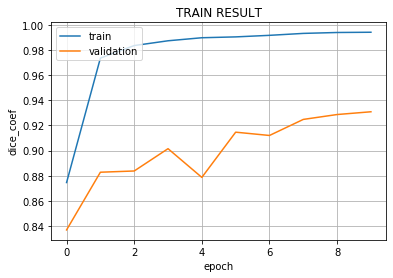

In [0]:
model = uresnet(Conv2D_34skipblock, IMG_ROWS, IMG_COLS, IMG_CHANNELS)

model_checkpoint = ModelCheckpoint('weights_layer_0_v1.h5', monitor='val_loss', save_best_only=True)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE, 
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('TRAIN RESULT')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.rcParams["figure.figsize"] = [100,100]
plt.show()

Train on 1024 samples, validate on 256 samples
Epoch 1/5
1024/1024 [==============================] - 473s 462ms/step - loss: -0.9950 - dice_coef: 0.9950 - val_loss: -0.9302 - val_dice_coef: 0.9302
Epoch 2/5
1024/1024 [==============================] - 473s 462ms/step - loss: -0.9949 - dice_coef: 0.9949 - val_loss: -0.9350 - val_dice_coef: 0.9350
Epoch 3/5
1024/1024 [==============================] - 473s 462ms/step - loss: -0.9953 - dice_coef: 0.9953 - val_loss: -0.9411 - val_dice_coef: 0.9411
Epoch 4/5
1024/1024 [==============================] - 473s 462ms/step - loss: -0.9956 - dice_coef: 0.9956 - val_loss: -0.9448 - val_dice_coef: 0.9448
Epoch 5/5
1024/1024 [==============================] - 473s 462ms/step - loss: -0.9952 - dice_coef: 0.9952 - val_loss: -0.9516 - val_dice_coef: 0.9516


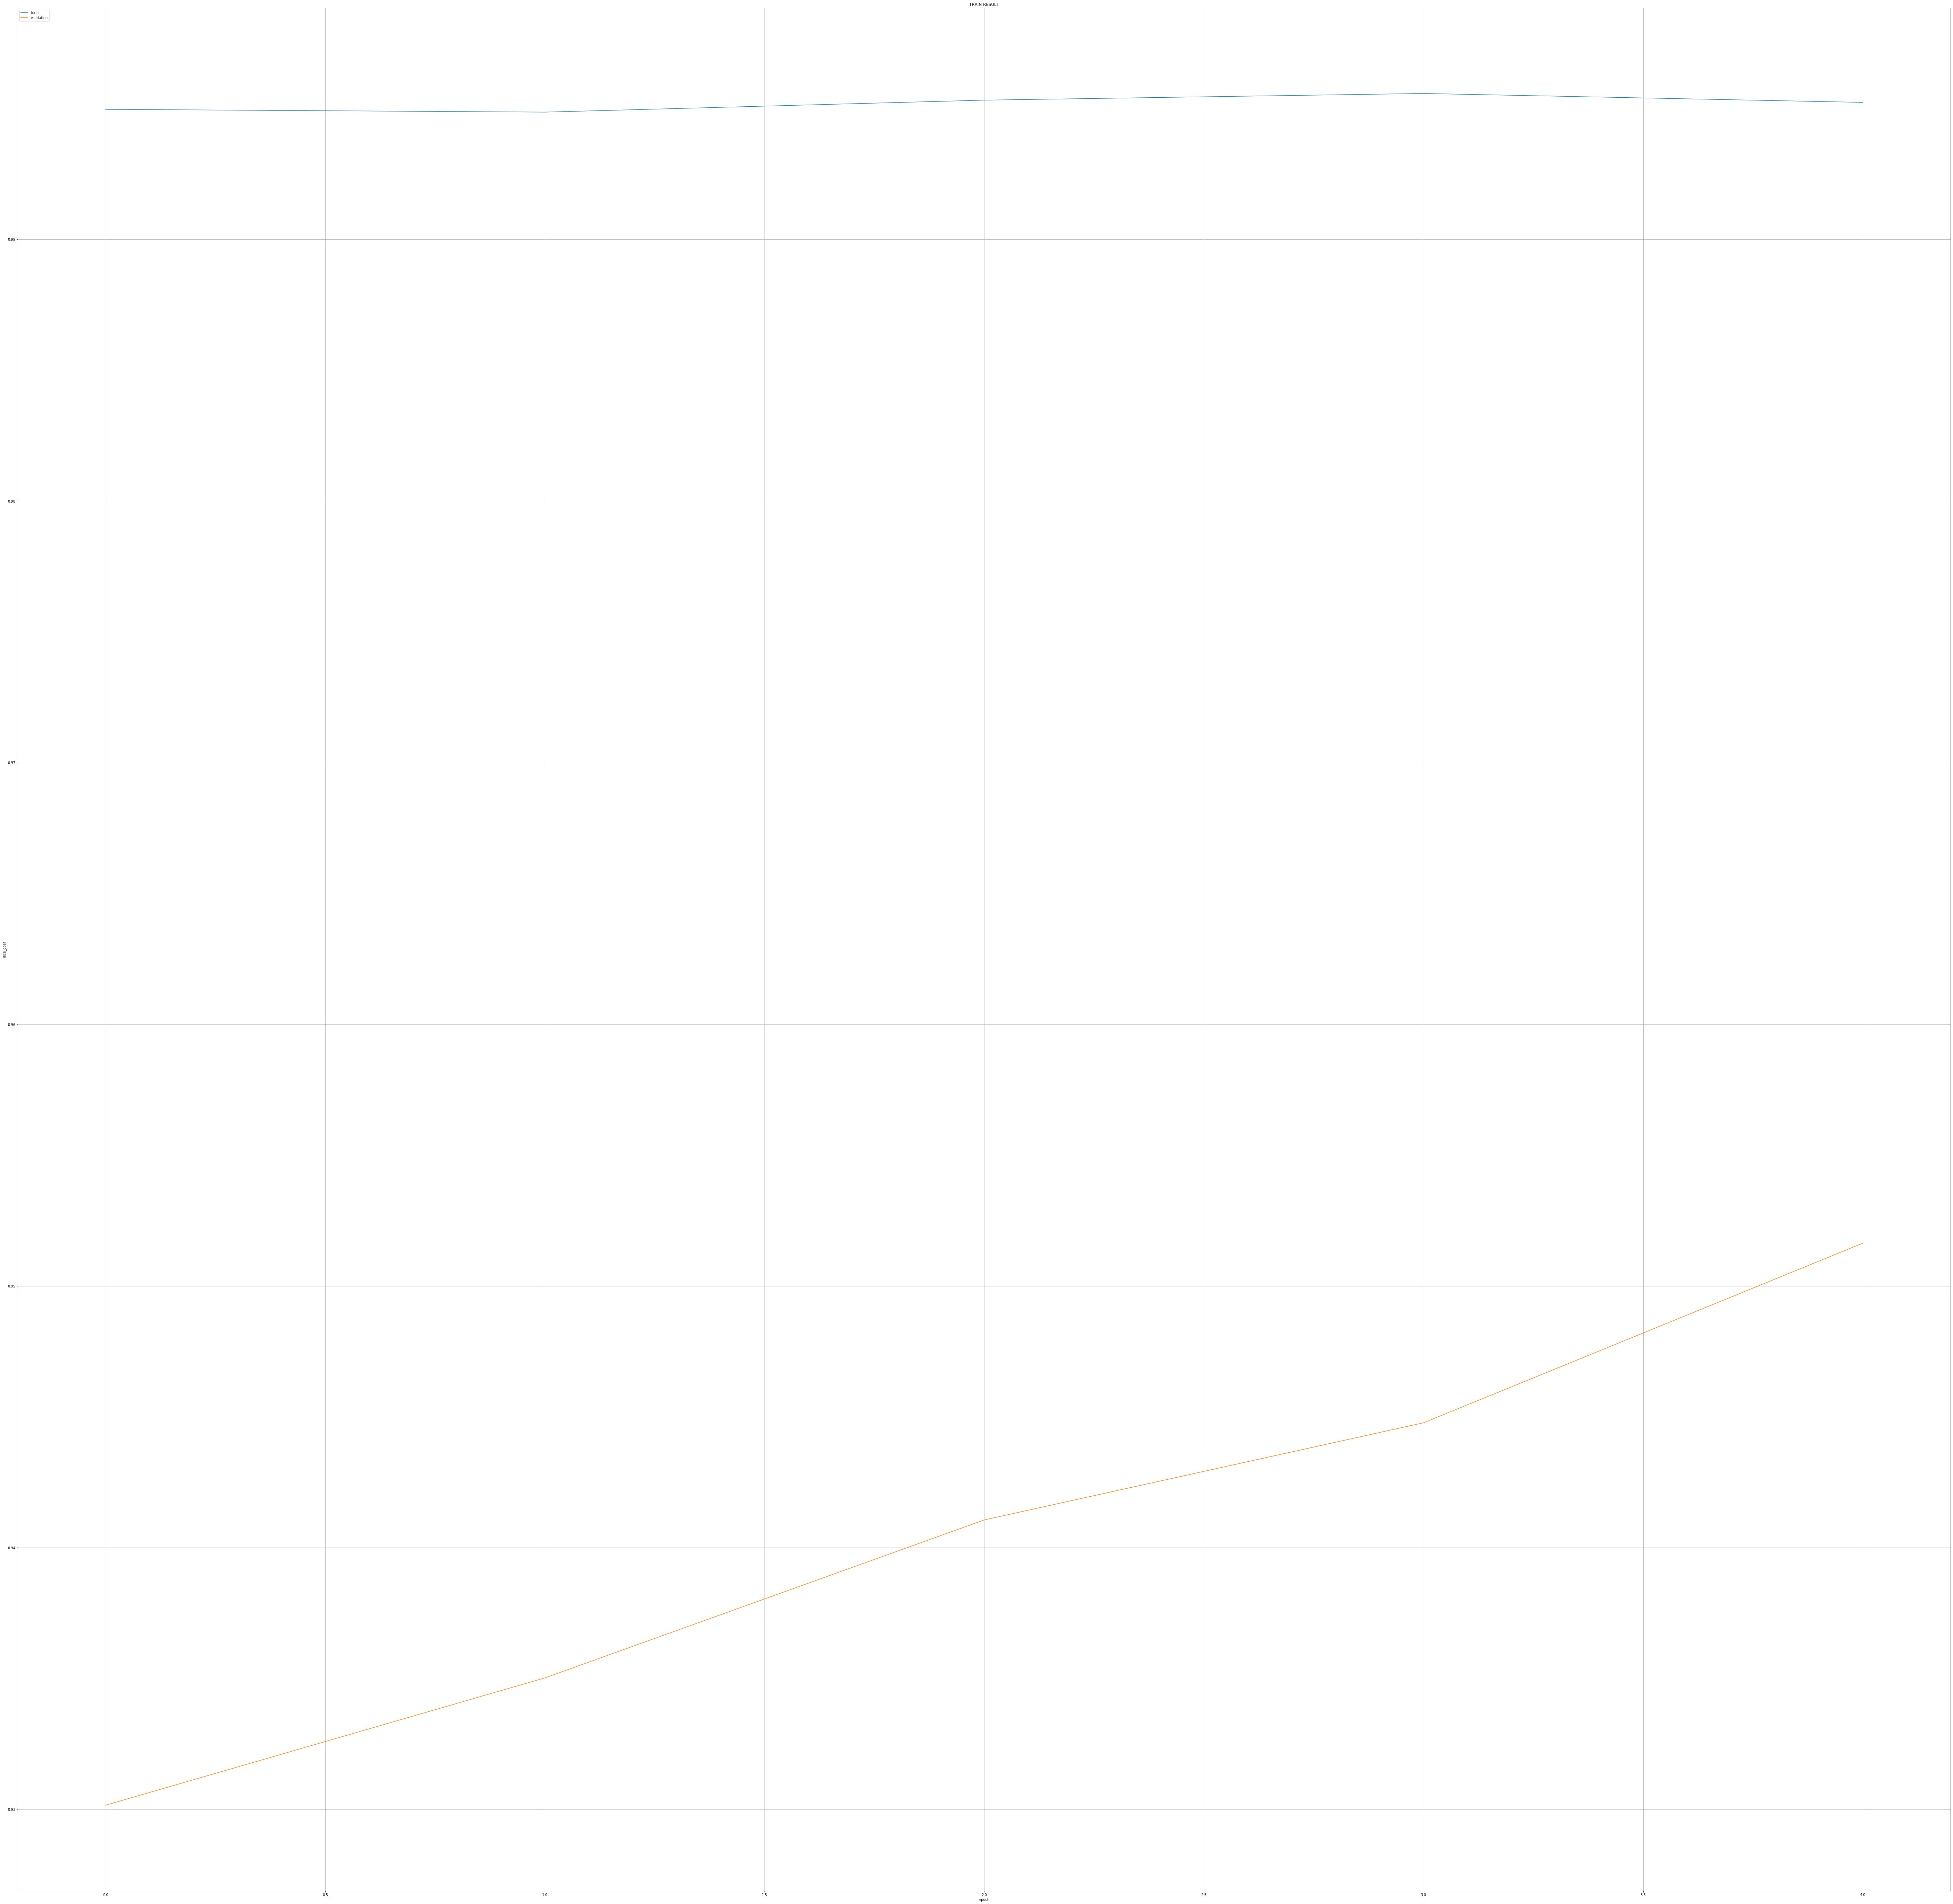

In [0]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=5, verbose=VERBOSE, 
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('TRAIN RESULT')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.rcParams["figure.figsize"] = [100,100]
plt.show()